In [53]:
# Dataset Downloaded from https://www.kaggle.com/datasets/mejbahahammad/movielens-20m-dataset
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

<h4>Load Data and Process Data</h4>

In [2]:
ratingDf = pd.read_csv("Dataset/ratings.csv")
ratingDf.shape

(20000263, 4)

In [3]:
ratingDf.userId.nunique()

138493

In [4]:
ratingDf.movieId.nunique()

26744

In [5]:
ratingDf.rating.value_counts()

4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: rating, dtype: int64

In [6]:
ratingDf.userId = ratingDf.userId.astype(str).astype(int)
ratingDf.movieId = ratingDf.movieId.astype(str).astype(int)
ratingDf.rating = ratingDf.rating.astype(str).astype(float)
ratingDf.timestamp = pd.to_datetime(ratingDf.timestamp, unit='s')

ratingDf.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [7]:
n_users = ratingDf.userId.unique().shape[0]
n_movies = ratingDf.movieId.unique().shape[0]
n_ratings = ratingDf.shape[0]
avg_ratings_per_user = n_ratings / n_users

In [8]:
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  138493
Number of unique movies:  26744
Number of total ratings:  20000263
Average number of ratings per user:  144.4135299257002


In [9]:
movieIndex = ratingDf.groupby('movieId').count().sort_values(by='rating', ascending=False)[0:1000].index
ratingDfX2 = ratingDf[ratingDf.movieId.isin(movieIndex)]
ratingDfX2.count()

userId       12840344
movieId      12840344
rating       12840344
timestamp    12840344
dtype: int64

In [10]:
userIndex = ratingDfX2.groupby('userId').count().sort_values(by='userId', ascending=False).sample(n=1000, random_state=2018).index
ratingDfX3 = ratingDfX2[ratingDfX2.userId.isin(userIndex)]
ratingDfX3.count()

userId       93411
movieId      93411
rating       93411
timestamp    93411
dtype: int64

In [11]:
movies = ratingDfX3.movieId.unique()
moviesDf = pd.DataFrame(data=movies, columns=['originalMovieId'])
moviesDf['newMovieId'] = moviesDf.index+1

In [12]:
users = ratingDfX3.userId.unique()
usersDf = pd.DataFrame(data=users,columns=['originalUserId'])
usersDf['newUserId'] = usersDf.index+1

In [13]:
ratingDfX3 = ratingDfX3.merge(moviesDf, left_on='movieId', right_on='originalMovieId')
ratingDfX3.drop(labels='originalMovieId',axis=1,inplace=True)
ratingDfX3 = ratingDfX3.merge(usersDf, left_on='userId', right_on='originalUserId')
ratingDfX3.drop(labels='originalUserId', axis=1, inplace=True)


In [14]:
n_users = ratingDfX3.userId.unique().shape[0]
n_movies = ratingDfX3.movieId.unique().shape[0]
n_ratings = ratingDfX3.shape[0]
avg_ratings_per_user = n_ratings / n_users

In [15]:
print('Number of unique users: ', n_users)
print('Number of unique movies: ', n_movies)
print('Number of total ratings: ', n_ratings)
print('Average number of ratings per user: ', avg_ratings_per_user)

Number of unique users:  1000
Number of unique movies:  1000
Number of total ratings:  93411
Average number of ratings per user:  93.411


In [16]:
X_train, X_test = train_test_split(ratingDfX3, test_size=0.10, shuffle=True, random_state=2018)
X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=2018)

In [17]:
print('Shape of train set:', X_train.shape)
print('Shape of validation set:',X_validation.shape)
print('Shape of test set: ',X_test.shape)

Shape of train set: (84069, 6)
Shape of validation set: (4671, 6)
Shape of test set:  (4671, 6)


In [18]:
print('Size of train set:', X_train.size)
print('Size of validation set:',X_validation.size)
print('Size of test set: ',X_test.size)

Size of train set: 504414
Size of validation set: 28026
Size of test set:  28026


In [49]:
n_latent_factor = 1
user_input = tf.keras.layers.Input(shape=[1], name='user')
user_embedding = tf.keras.layers.Embedding(input_dim=n_users+1,output_dim=n_latent_factor,name='user_embedding')(user_input)
user_vec = tf.keras.layers.Flatten(name='user_vec')(user_embedding)
movie_input = tf.keras.layers.Input(shape=[1], name='movie')
movie_embedding = tf.keras.layers.Embedding(input_dim=n_movies+1, output_dim=n_latent_factor, name='movie_embedding')(movie_input)
movie_vec = tf.keras.layers.Flatten(name='movie_vec')(movie_embedding)
product = tf.keras.layers.Dot(name='product', axes=1)([user_vec, movie_vec])
model = tf.keras.Model([user_input, movie_input], product)

In [50]:
model.compile('adam', 'mean_squared_error')
history = model.fit(x=[X_train.newUserId, X_train.newMovieId], y=X_train.rating, epochs=100,
                    validation_data=([X_validation.newUserId, X_validation.newMovieId], X_validation.rating),
                    verbose=1
                    )

Epoch 1/100
2628/2628 [==============================] - 8s 3ms/step - loss: 13.6126 - val_loss: 11.6623
Epoch 2/100
2628/2628 [==============================] - 8s 3ms/step - loss: 8.7608 - val_loss: 6.1106
Epoch 3/100
2628/2628 [==============================] - 7s 3ms/step - loss: 4.2756 - val_loss: 3.0420
Epoch 4/100
2628/2628 [==============================] - 8s 3ms/step - loss: 2.3096 - val_loss: 1.8574
Epoch 5/100
2628/2628 [==============================] - 7s 2ms/step - loss: 1.4883 - val_loss: 1.3007
Epoch 6/100
2628/2628 [==============================] - 8s 3ms/step - loss: 1.0982 - val_loss: 1.0271
Epoch 7/100
2628/2628 [==============================] - 8s 3ms/step - loss: 0.9087 - val_loss: 0.8884
Epoch 8/100
2628/2628 [==============================] - 7s 3ms/step - loss: 0.8143 - val_loss: 0.8177
Epoch 9/100
2628/2628 [==============================] - 5s 2ms/step - loss: 0.7660 - val_loss: 0.7795
Epoch 10/100
2628/2628 [==============================] - 6s 2ms/step -

<h4>Testing Model</h4>

Minimum MSE:  0.7293317317962646


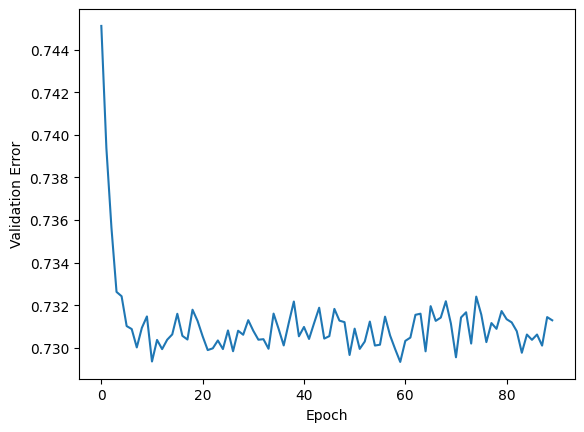

In [60]:
pd.Series(history.history['val_loss'][10:]).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Validation Error")
print('Minimum MSE: ', min(history.history['val_loss']))

In [56]:
pred = model.predict([X_test.newUserId,X_test.newMovieId])

146/146 [==============================] - 0s 3ms/step


array([[3.8914692],
       [3.659824 ],
       [3.5010915],
       ...,
       [3.2940898],
       [3.4858923],
       [4.18111  ]], dtype=float32)

In [57]:
mean_squared_error(X_test.rating,pred)

0.749263178626826

In [58]:
X_test.rating[:10], pred[:10]

C:\Users\Laptop House\AppData\Local\Temp\ipykernel_9520\4135463238.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_test.rating[:10], pred[:10]


(26487    3.0
 35264    4.0
 22639    1.5
 86800    2.5
 42210    4.0
 83729    2.5
 34333    4.0
 74144    5.0
 5931     4.0
 50053    5.0
 Name: rating, dtype: float64,
 array([[3.8914692],
        [3.659824 ],
        [3.5010915],
        [3.4756699],
        [3.9482074],
        [3.2750669],
        [3.9422674],
        [4.079718 ],
        [3.883641 ],
        [3.3886452]], dtype=float32))